In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))


import tensorflow as tf
import bayesflow as bf
import numpy as np


from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.models import Sequential

from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.summary_networks import DeepSet, HierarchicalNetwork, SetTransformer

from src.networks import AmortizedMixture, AmortizedPosteriorMixture
from src.models.MixtureNormal import model, modelFixedContext, configurator, constrain_parameters, constrained_parameter_names, generate_fixed_dataset


train = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 71, 7)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [2]:
#local_summary_net = Lambda(lambda x: tf.reduce_mean(x, axis=-2))
local_summary_net = DeepSet(summary_dim=1)

classification_net = Sequential([Dense(64, activation='relu') for _ in range(8)])
classification_net.add(Dense(3))


amortizer = AmortizedPosteriorMixture(
    amortized_posterior=AmortizedPosterior(
        inference_net=InvertibleNetwork(num_params=5, num_coupling_layers=10, coupling_design="spline"),
        summary_net=HierarchicalNetwork([local_summary_net, SetTransformer(input_dim=1, summary_dim=10)]),
        summary_loss_fun="MMD"
    ),
    amortized_mixture=AmortizedMixture(
        inference_net=classification_net, 
        local_summary_net=local_summary_net
    )
)

In [3]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configurator, checkpoint_path="checkpoints/training")

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [4]:
%time
if train:
    h = trainer.train_online(epochs=250, iterations_per_epoch=500, batch_size=128)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


Training epoch 250: 100%|██████████| 500/500 [03:47<00:00,  2.19it/s, Epoch: 250, Iter: 500,posterior.loss: -3.067,mixture.loss: 0.167,W.Decay: 0.056,Avg.posterior.loss: -1.343,Avg.mixture.loss: 0.266,Avg.W.Decay: 0.056,LR: 0.00E+00]


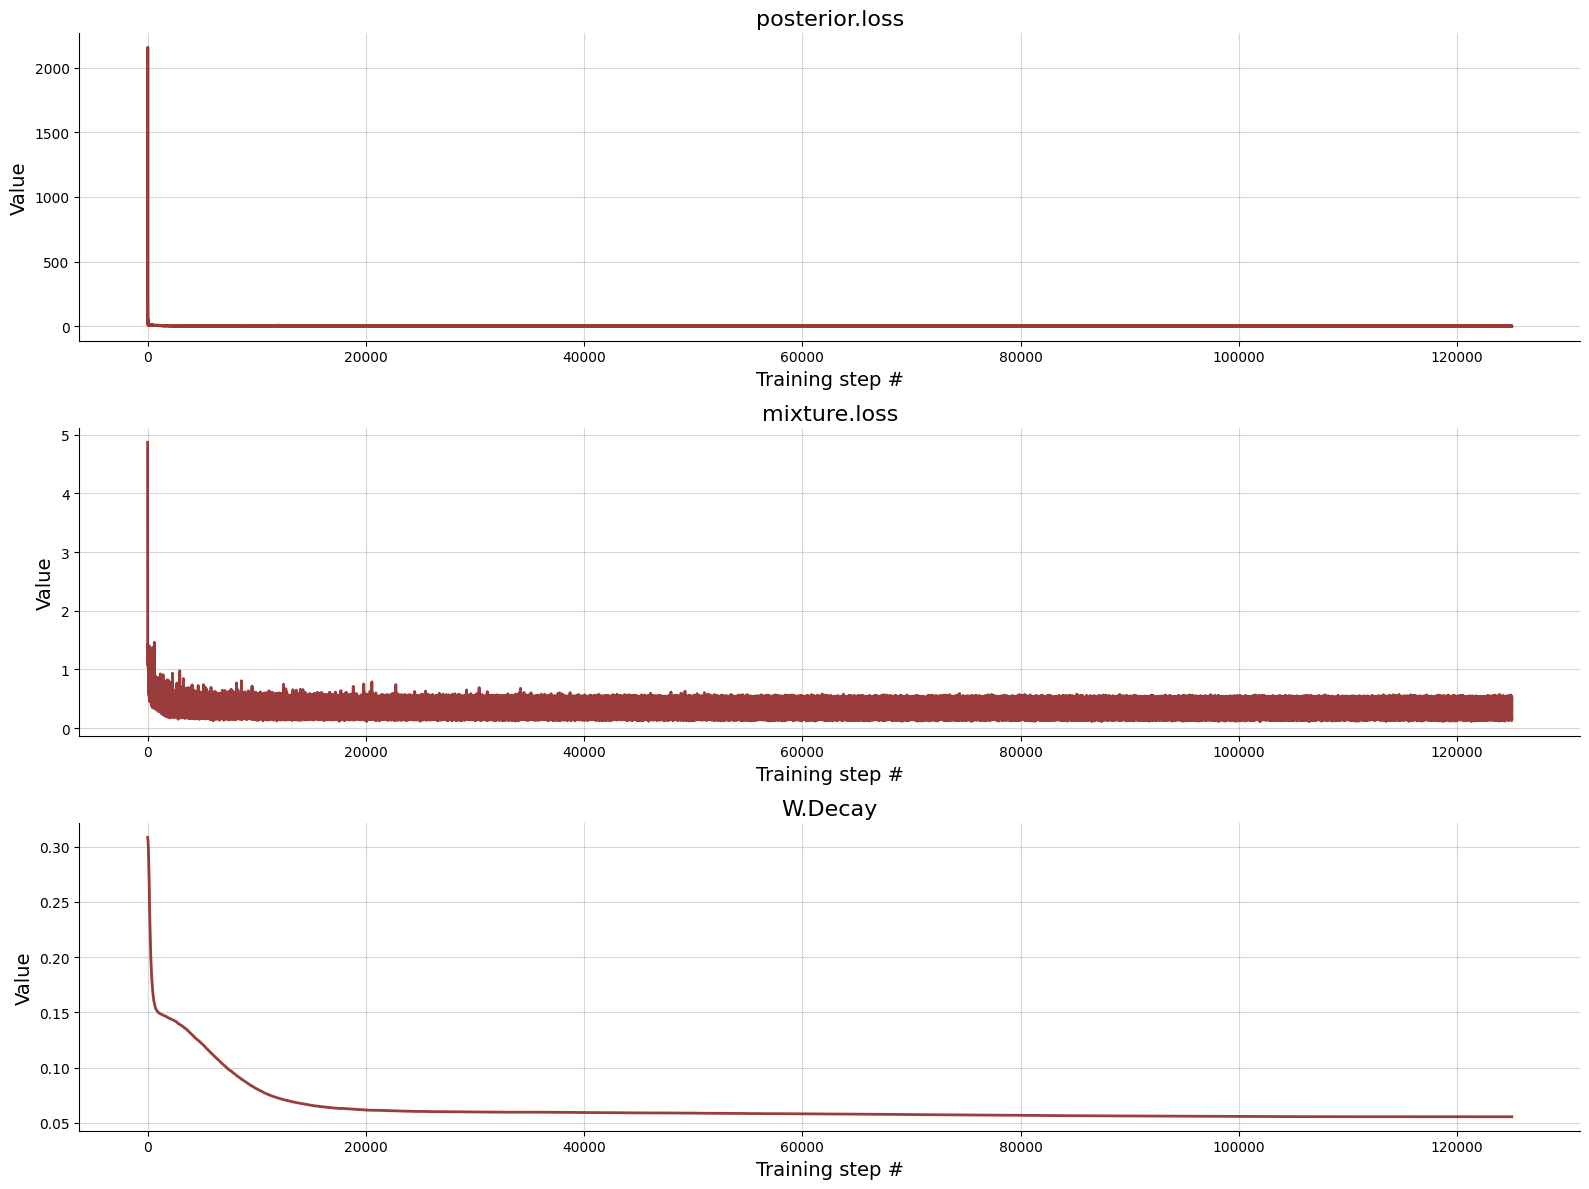

In [5]:
if train:
    f  = bf.diagnostics.plot_losses(h)

In [6]:
modelFixed = modelFixedContext(n_obs=200, n_rep=5)

df = configurator(modelFixed(1000))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 200, 6)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [7]:
df["posterior_inputs"]["direct_conditions"]

array([[200.,   5.],
       [200.,   5.],
       [200.,   5.],
       ...,
       [200.,   5.],
       [200.,   5.],
       [200.,   5.]], dtype=float32)

In [8]:
(z, _), _ = amortizer(df)

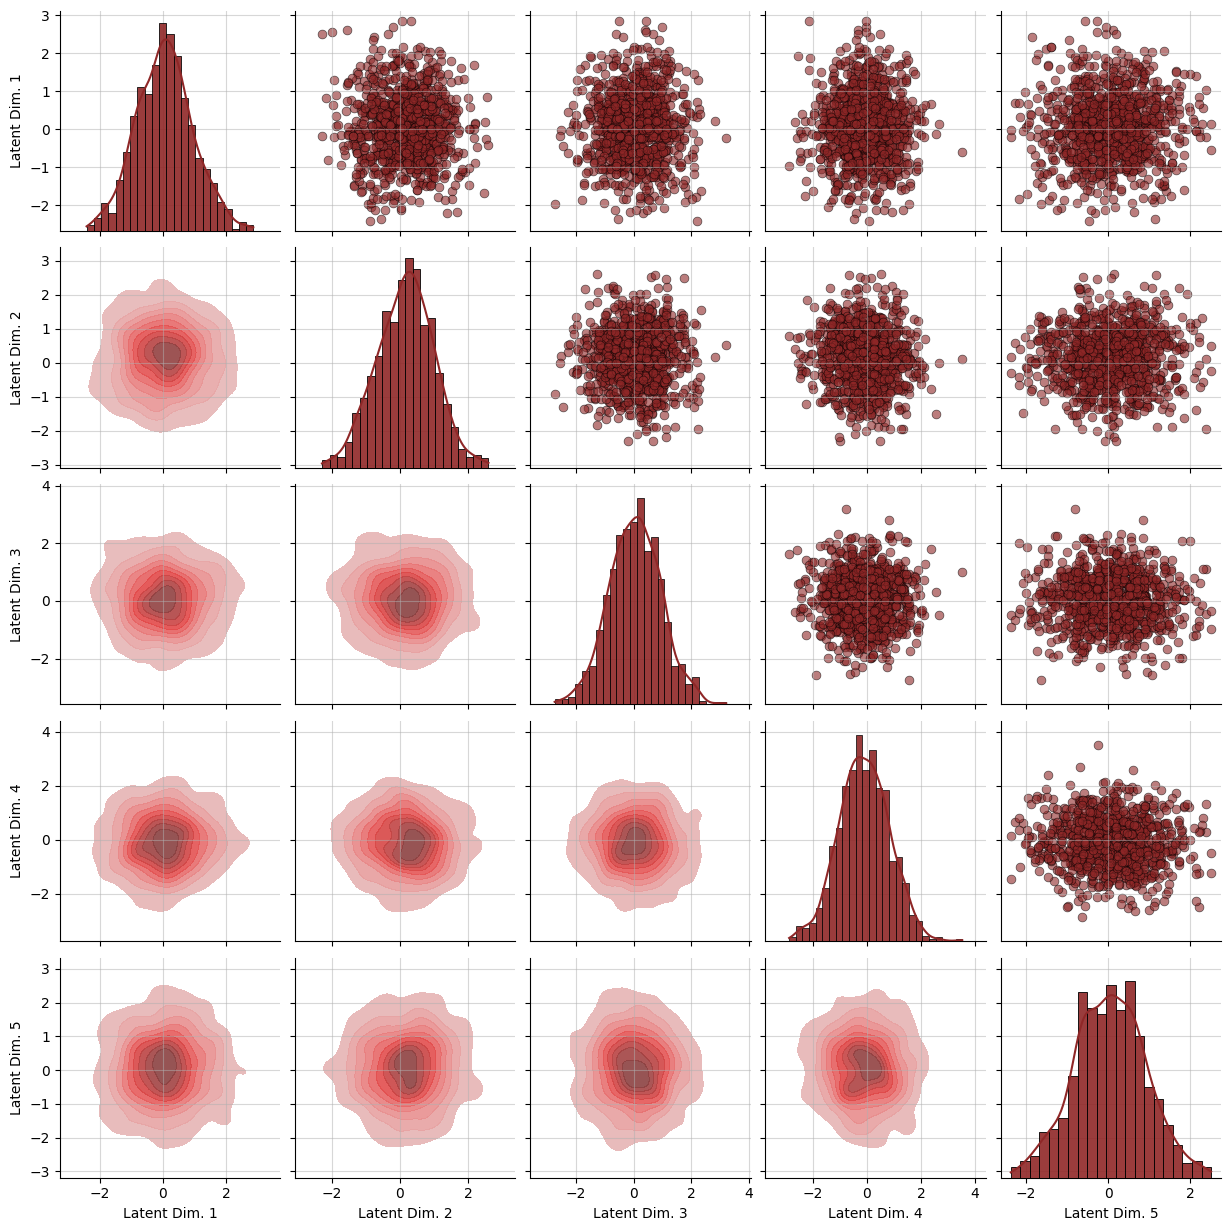

In [9]:
f = bf.diagnostics.plot_latent_space_2d(z)

## Calibration (parameter posterior approximator)

### Unonstrained space

In [10]:
prior = df['posterior_inputs']['parameters']
posterior = amortizer.amortized_posterior.sample(df['posterior_inputs'], n_samples=1000)

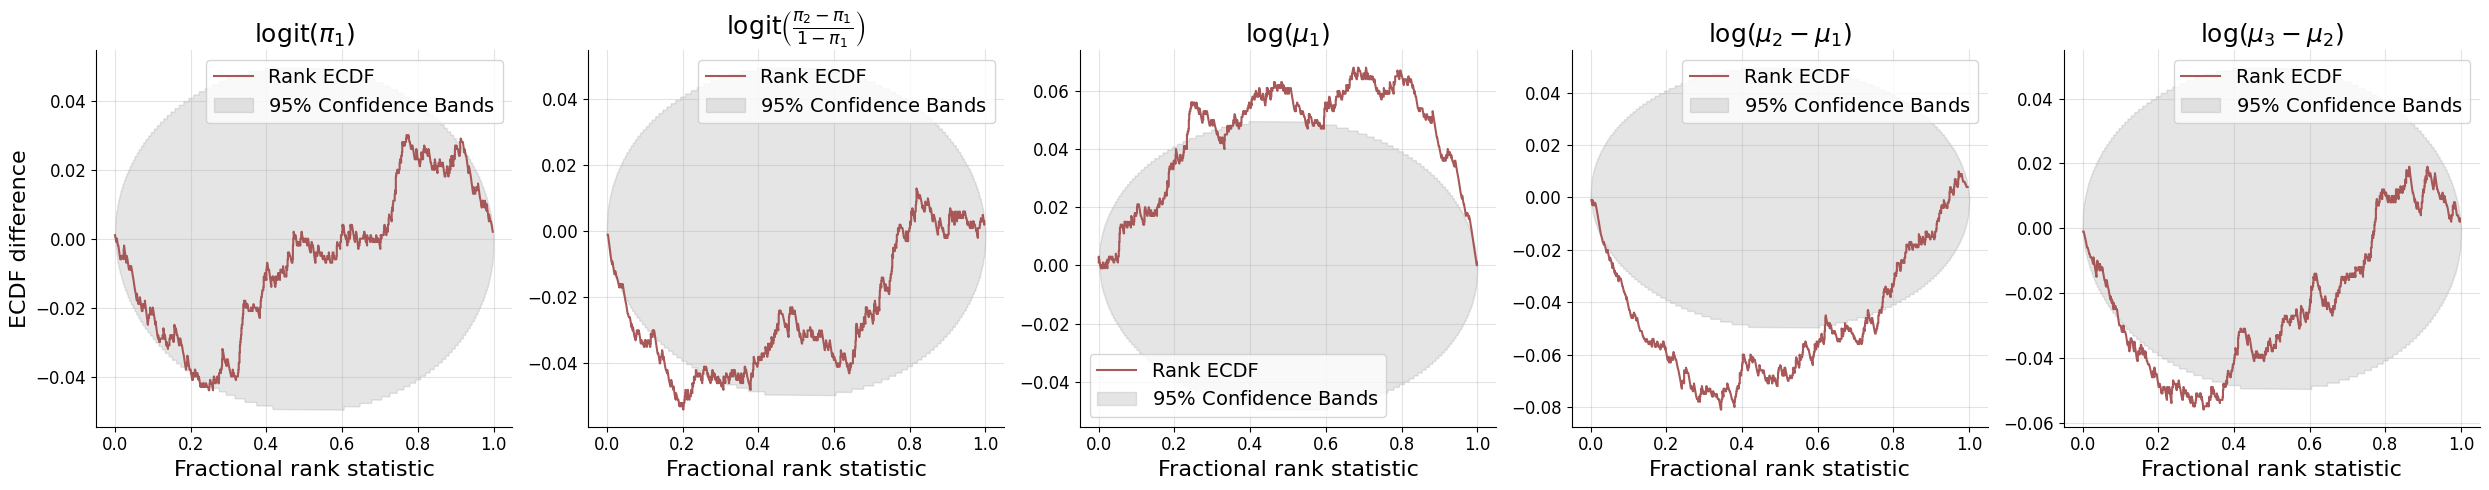

In [11]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, difference=True, param_names=model.param_names)

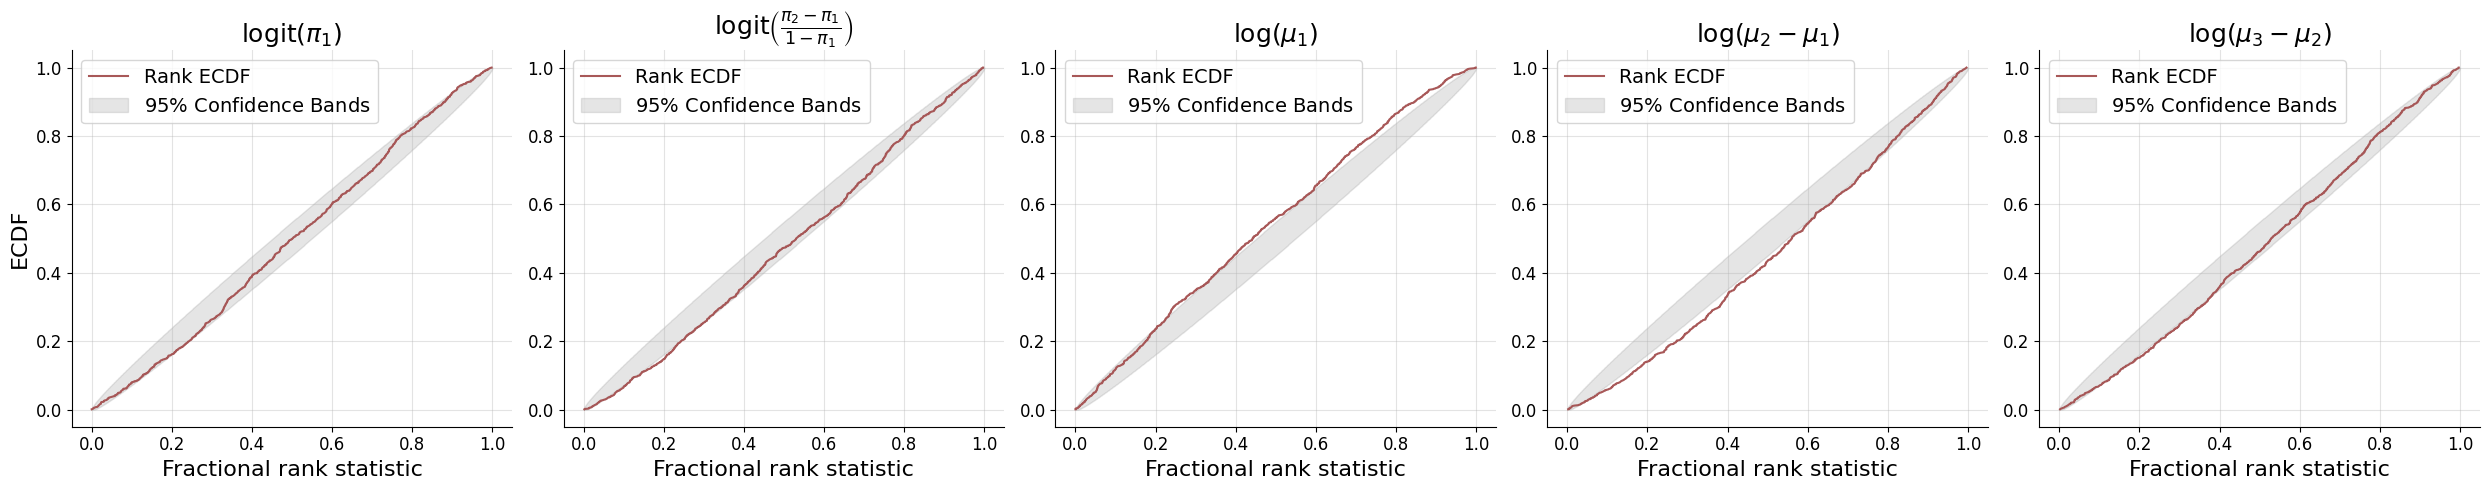

In [12]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, param_names=model.param_names)

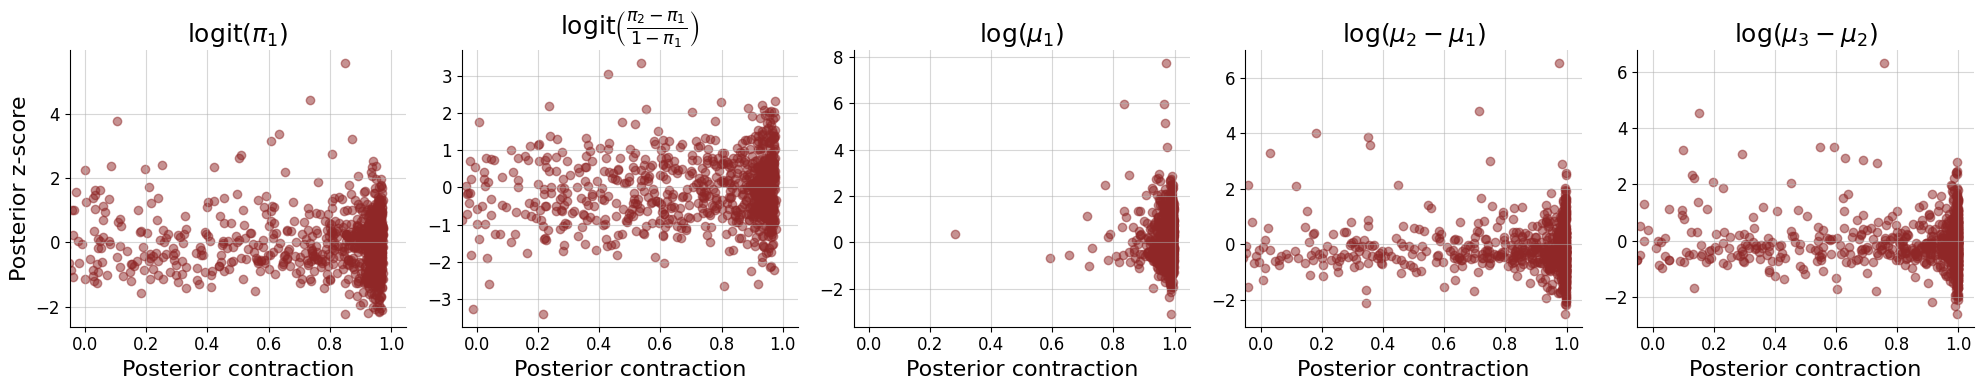

In [13]:
f = bf.diagnostics.plot_z_score_contraction(posterior, prior, param_names=model.param_names)

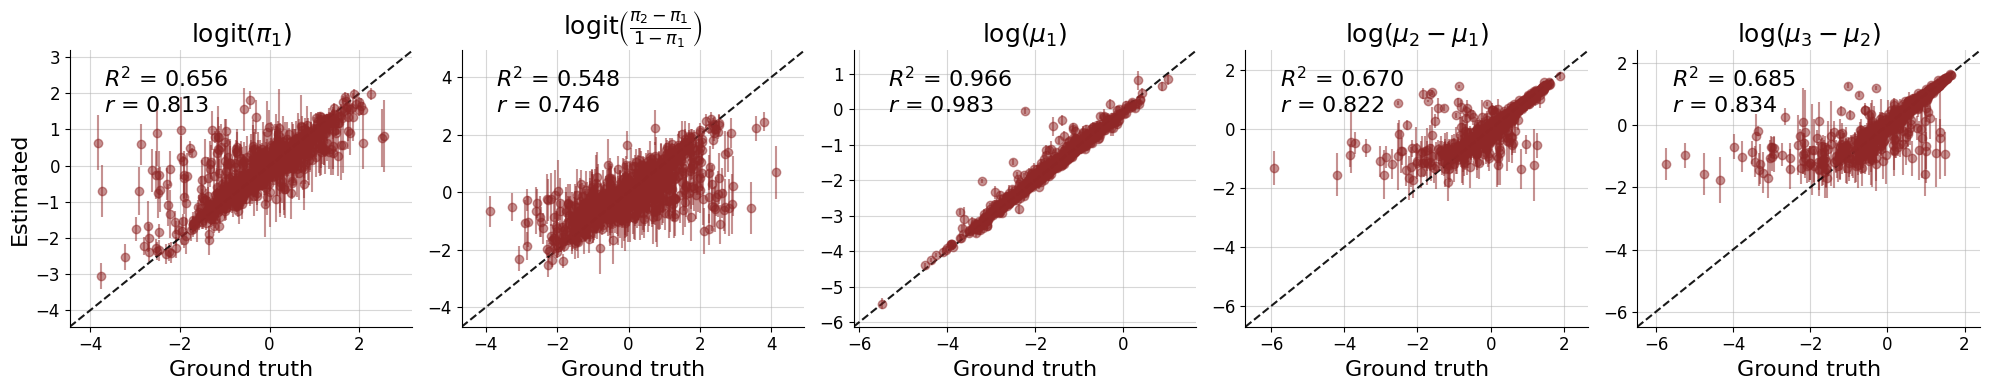

In [14]:
f = bf.diagnostics.plot_recovery(posterior, prior, param_names=model.param_names)

## Calibration (parameter posterior approximator)

### Constrained space

In [15]:
prior = constrain_parameters(prior)
posterior = constrain_parameters(posterior)

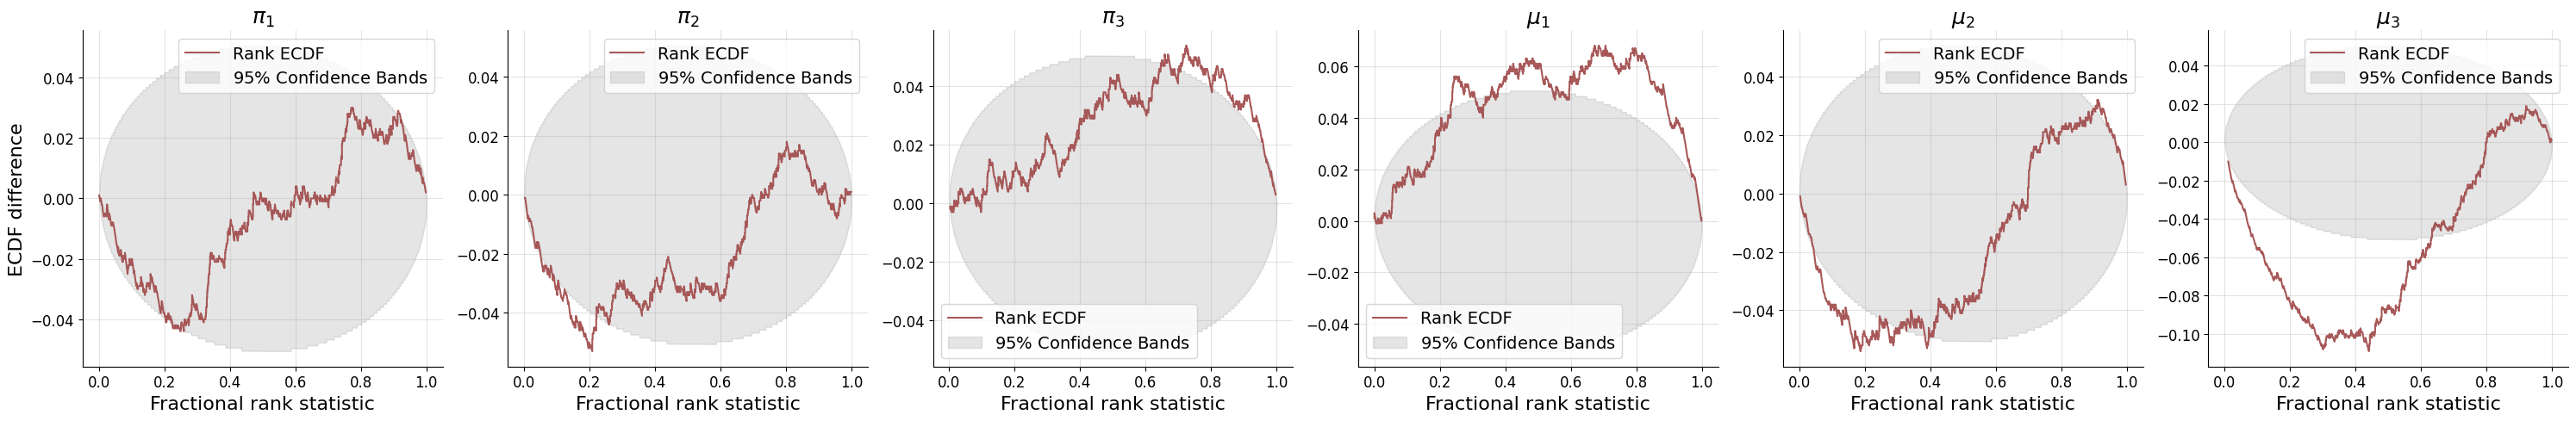

In [16]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, difference=True, param_names=constrained_parameter_names)

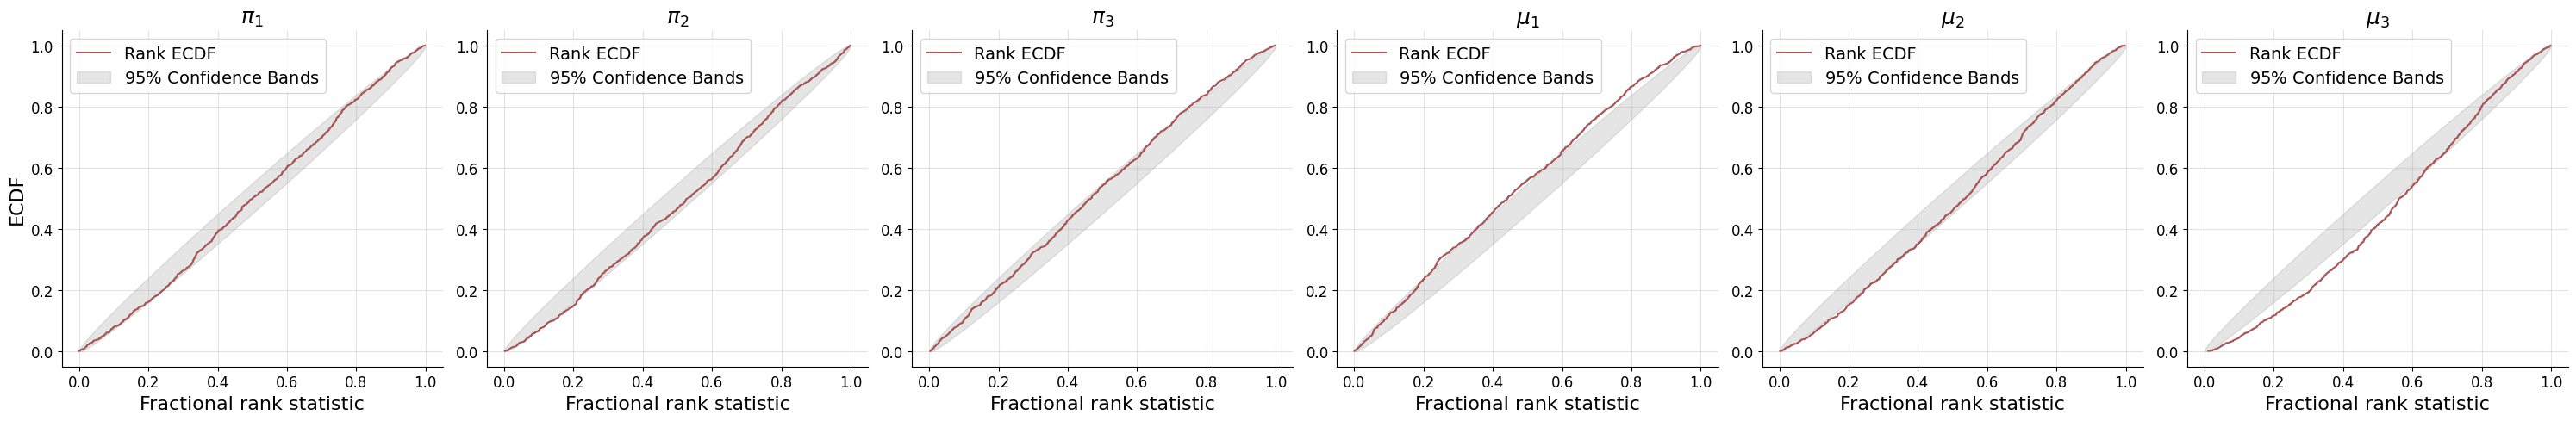

In [17]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, param_names=constrained_parameter_names)

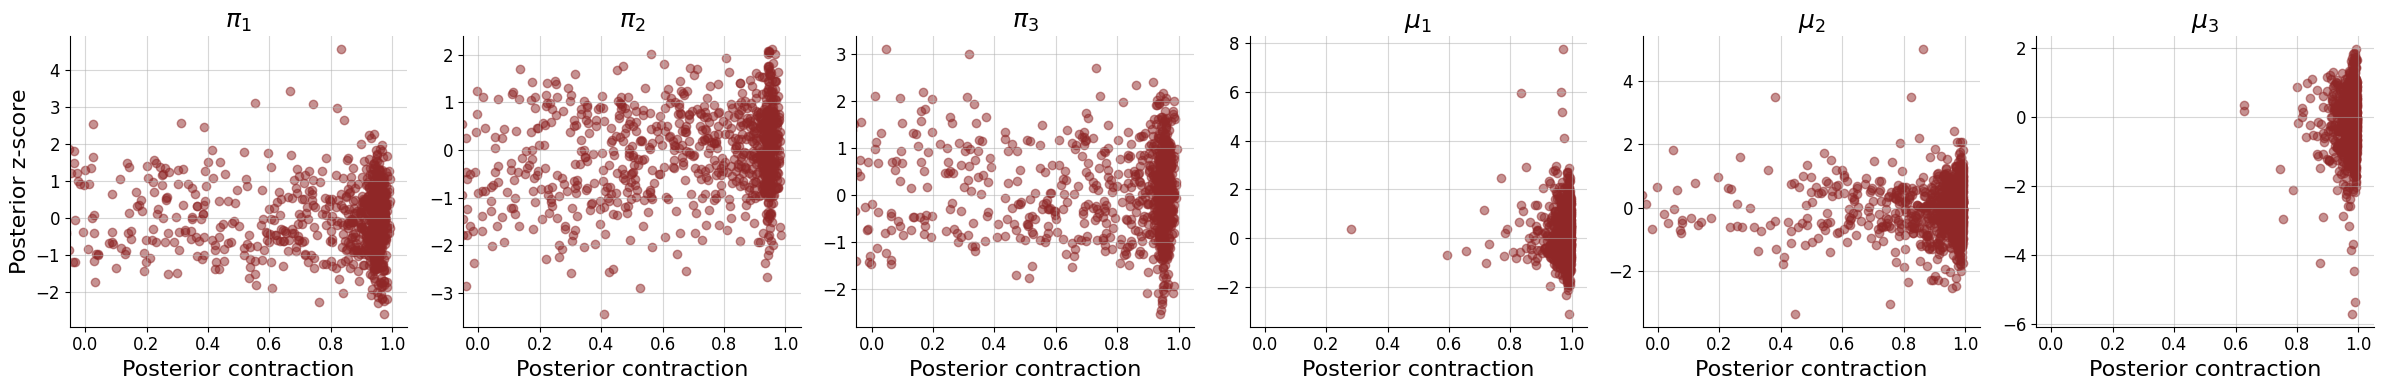

In [18]:
f = bf.diagnostics.plot_z_score_contraction(posterior, prior, param_names=constrained_parameter_names)

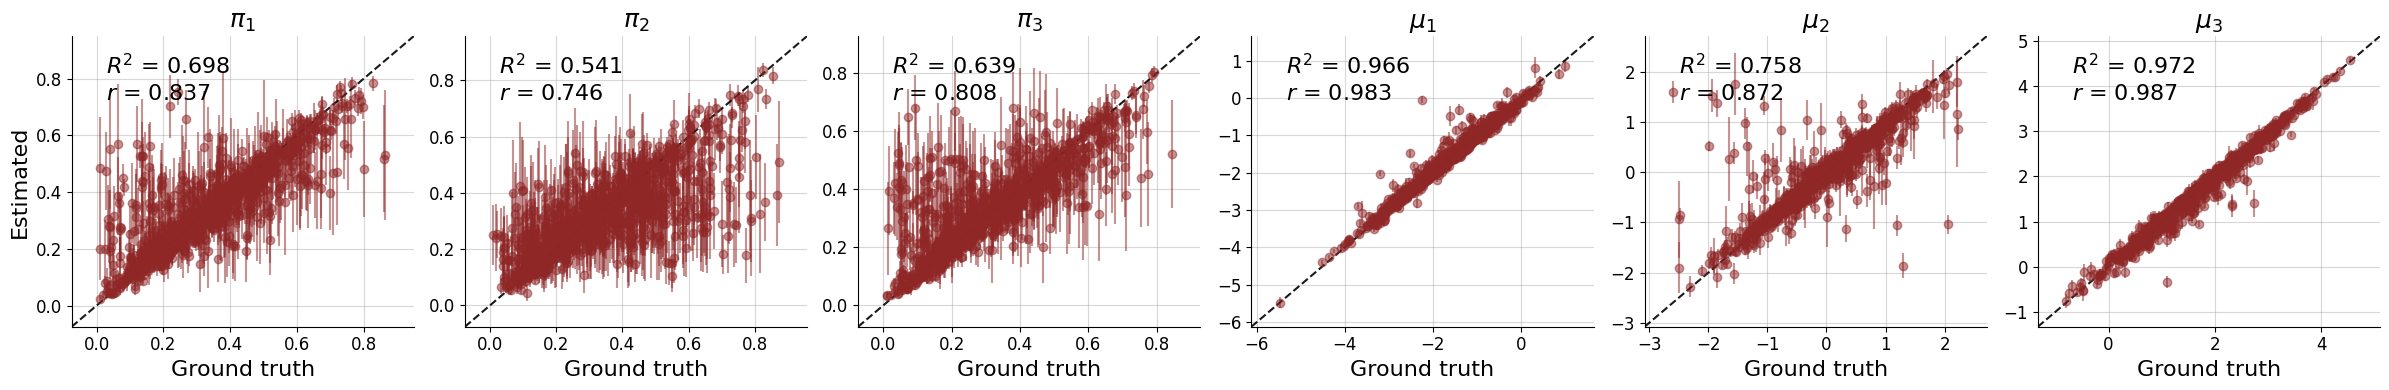

In [19]:
f = bf.diagnostics.plot_recovery(posterior, prior, param_names=constrained_parameter_names)

In [20]:
fixed_data = generate_fixed_dataset(n_obs=[1, 50, 50, 50], n_rep=2, mu=[0, -1, 0, 1])

fixed_posterior, fixed_mixture = amortizer.sample(fixed_data, n_samples=1000)